In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader,random_split,WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

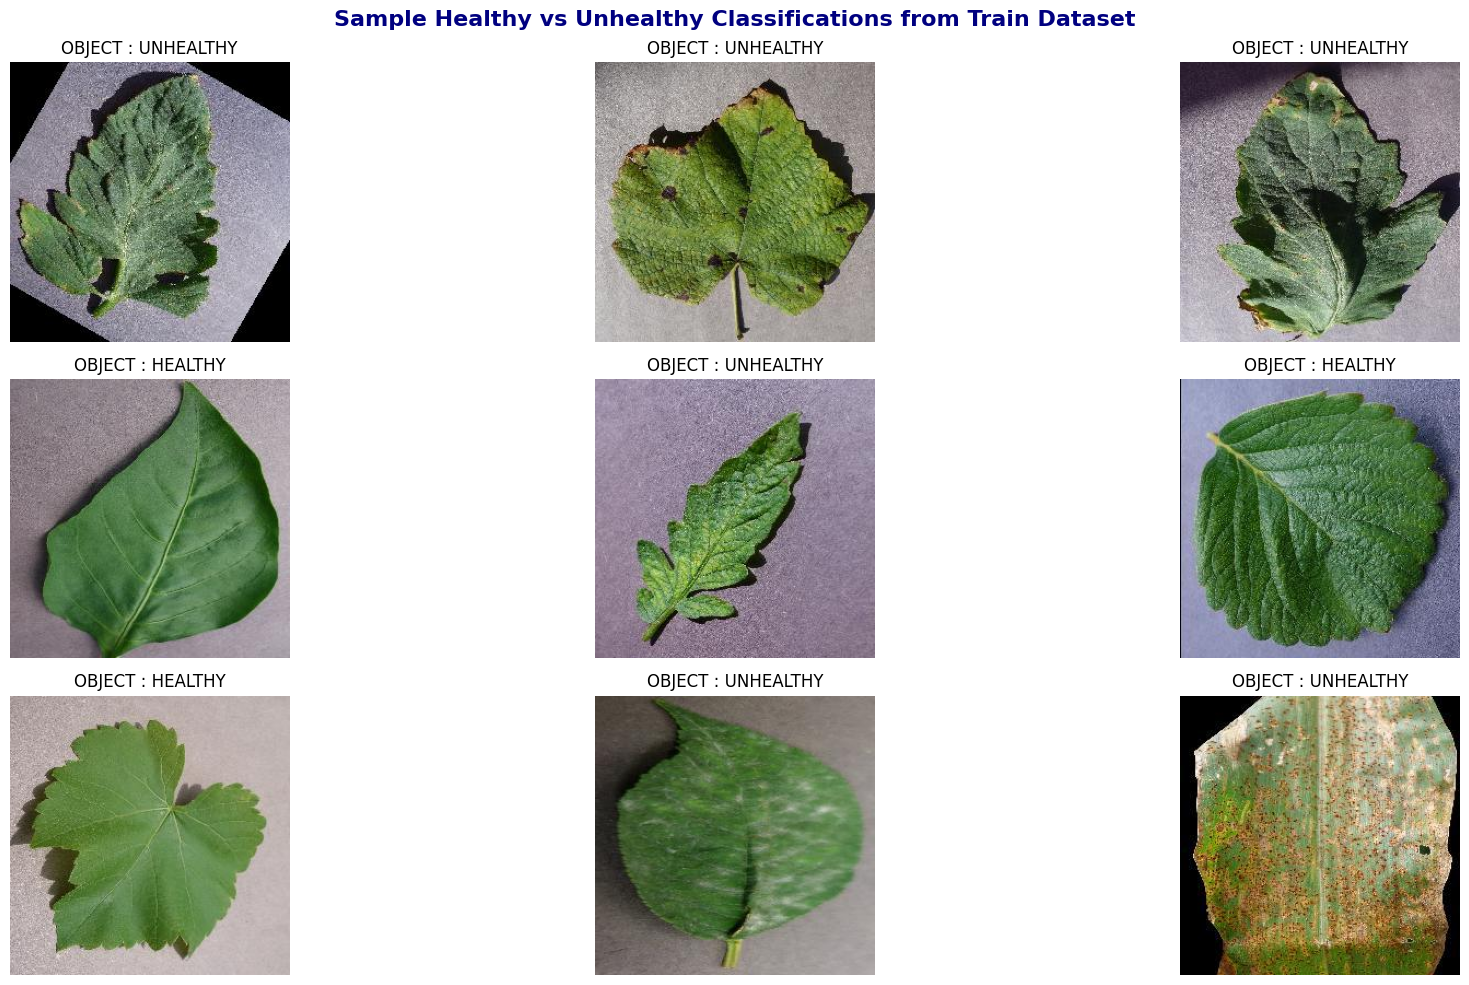

In [2]:
plotdata=datasets.ImageFolder(root=r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\healthcheck")
classname=plotdata.classes
plt.style.use("seaborn-v0_8-muted")
plt.figure(figsize=(20,10))
rows,cols=3,3
for i in range(1,rows*cols+1):
    plt.subplot(rows,cols,i)
    randomid=torch.randint(0,len(plotdata),size=[1]).item()
    img,label=plotdata[randomid]
    plt.imshow(img)
    plt.title(f"OBJECT : {classname[label]}")
    plt.axis(False)
plt.suptitle("Sample Healthy vs Unhealthy Classifications from Train Dataset", fontsize=16, fontweight='bold', color='navy')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.992157].


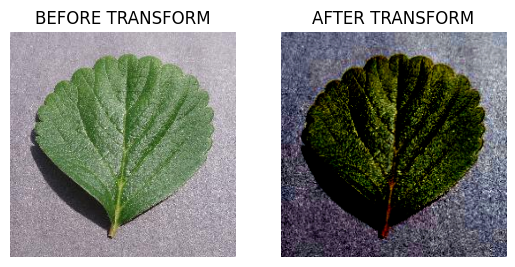

In [3]:
from pathlib import Path
from PIL import Image
import random
imagepath=Path(r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\Healthcheck")
data_transform = v2.Compose([
    v2.Resize((229, 229)),                            # Resize to AlexNet input size
    v2.ToImage(),                                     # Needed before color transforms
    v2.RandomHorizontalFlip(p=0.3),                   # Flip
    v2.ColorJitter(                                   # Randomly adjust brightness, contrast, etc.
        brightness=0.2,                               # ±20%
        contrast=0.2,
        saturation=0.2,
        hue=0.1                                       # hue ∈ [-0.1, 0.1]
    ),
    v2.RandomAutocontrast(p=0.2),                     # Random autocontrast
    v2.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Sharpness boost
    v2.ToDtype(torch.float32, scale=True),            # Scale to [0, 1]
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
def plot_original_transform(imagpath,transform):
    randomimglist=random.choice(list(imagepath.rglob('*.jpg')))
    image=Image.open(randomimglist).convert("RGB")
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("BEFORE TRANSFORM")
    plt.axis(False)
    transform_img=transform(image)
    plt.subplot(1,2,2)
    plt.imshow(transform_img.permute(1,2,0))
    plt.title("AFTER TRANSFORM")
    plt.axis(False)
plot_original_transform(imagepath,data_transform)

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
def check_imbalance_class(data):
    labels=[sample[1] for sample in data]
    class_count=Counter(labels)
    
    class_names = data.classes

    for i, counts in class_count.items():
     print(f"{class_names[i]}: {counts}")
     
    counts=np.array(list(class_count.values()))
    imbalance_ratio=counts.max()/counts.min()
    print(f"CLASS IMBALANCE RATION : {imbalance_ratio:.2f}")


     
    plt.figure(figsize=(20, 5))
    plt.bar([class_names[i] for i in class_count.keys()], class_count.values())
    plt.xticks(rotation=60, ha='right', fontsize=6)  # rotated + smaller font
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

HEALTHY: 13822
UNHEALTHY: 15636
CLASS IMBALANCE RATION : 1.13


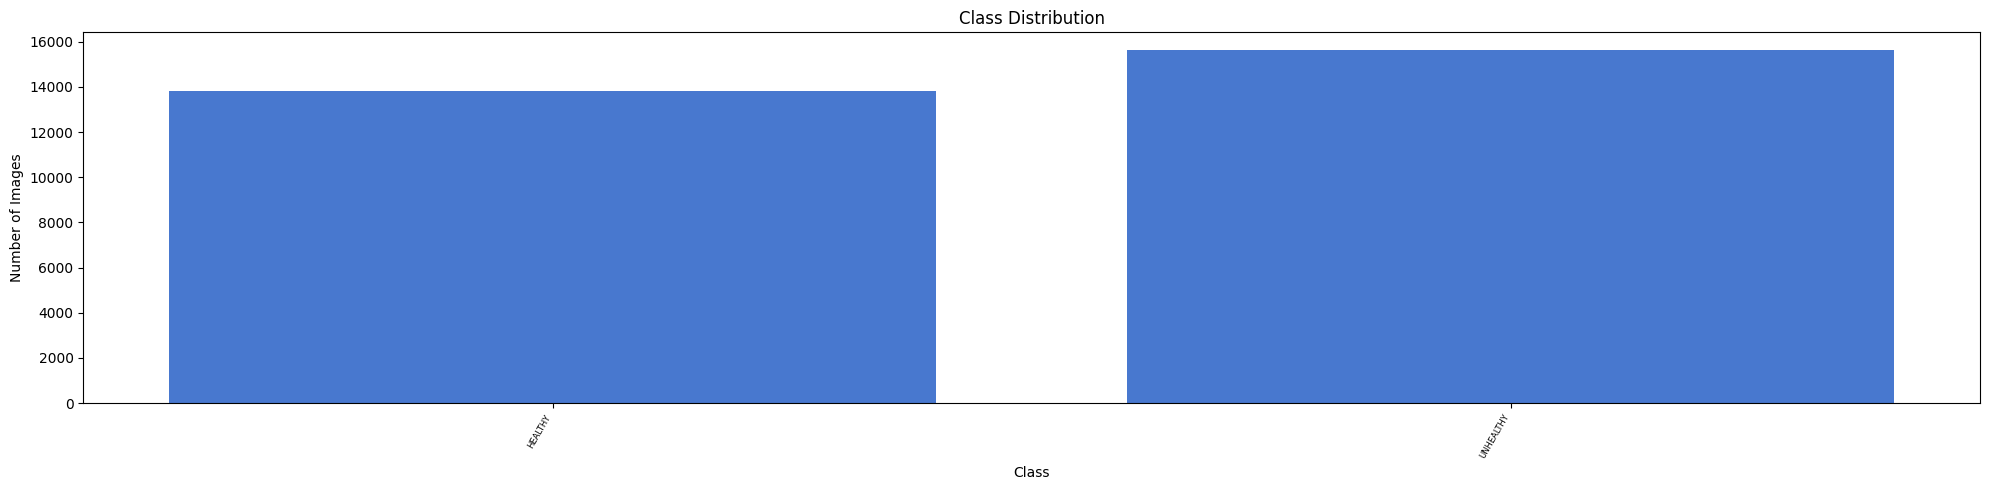

In [10]:

check_imbalance_class(plotdata)

In [4]:
import os
def getloader(root_directory, batch_size, train_ratio, image_size):
    # Transform (ImageNet normalization for pretrained models like EfficientNet)
    data_transform = v2.Compose([
        v2.Resize((image_size, image_size)),
        v2.ToImage(),
        v2.RandomHorizontalFlip(p=0.3),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load dataset
    full_dataset = datasets.ImageFolder(root=root_directory, transform=data_transform)

    # Train-test split
    train_size = int(train_ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Calculate class weights for sampler (to handle class imbalance)
    train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
    class_counts = Counter(train_labels)
    class_weights = {label: 1.0 / count for label, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,num_workers=os.cpu_count())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=os.cpu_count())

    return train_loader, test_loader

In [5]:
root=r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\Healthcheck"
trainloader,testloader=getloader(root,32,0.8,224)
torch.cuda.empty_cache()

In [6]:
from collections import Counter
import torch

def count_class_distribution(dataloader):
    class_counts = Counter()
    for _, labels in dataloader:
        if isinstance(labels, torch.Tensor):
            labels = labels.tolist()
        class_counts.update(labels)
    return class_counts
train_class_counts = count_class_distribution(trainloader)
test_class_counts = count_class_distribution(testloader)

print("Train Class Distribution:", dict(train_class_counts))
print("Test Class Distribution:", dict(test_class_counts))


Train Class Distribution: {0: 11818, 1: 11748}
Test Class Distribution: {0: 2761, 1: 3131}


In [7]:
len(trainloader)*32+len(testloader)*32

29504

In [24]:
train_feature_batch,train_label=next(iter(trainloader))
test_feature_batch,test_label=next(iter(testloader))

In [25]:
train_feature_batch.shape

torch.Size([32, 3, 299, 299])

In [8]:
from torchvision import models

# Load pre-trained AlexNet
# vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
efficientnet=models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights)

c:\Users\Avijit\Desktop\AgriAssure\AGROENV\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Just test a batch
x, y = next(iter(trainloader))
print("Image batch shape:", x.shape)
print("Label batch shape:", y.shape)
print("Unique labels:", torch.unique(y))


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Unique labels: tensor([0, 1])


In [11]:
from torchinfo import summary
summary(efficientnet)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 648
│    │    └─BatchNorm2d: 3-2                            48
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─FusedMBConv: 3-4                            5,232
│    │    └─FusedMBConv: 3-5                            5,232
│    └─Sequential: 2-3                                  --
│    │    └─FusedMBConv: 3-6                            25,632
│    │    └─FusedMBConv: 3-7                            92,640
│    │    └─FusedMBConv: 3-8                            92,640
│    │    └─FusedMBConv: 3-9                            92,640
│    └─Sequential: 2-4                                  --
│    │    └─FusedMBConv: 3-1

In [12]:
def show_trainable_layers(model):
    print("🔍 Trainable layers in the model:\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"✅ {name}")
        else:
            print(f"❌ {name}")


In [127]:
from torchvision import models
import torch.nn as nn

def get_efficientnet_model(num_class, mode='no_tune'):
    model =models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights)

    # ✅ Replace final layer inside classifier
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_class)

    if mode == 'no_tune':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[-1].parameters():
            param.requires_grad = True

    elif mode == 'partial':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    elif mode == 'full':
        for param in model.parameters():
            param.requires_grad = True

    return model


In [131]:
from torchinfo import summary 
device='cuda' if torch.cuda.is_available() else 'cpu' 
model=get_efficientnet_model(num_class=1,mode='no_tune').to(device) 
torch.cuda.empty_cache() 

c:\Users\Avijit\Desktop\AgriAssure\AGROENV\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [132]:
classname=plotdata.classes
classname

['HEALTHY', 'UNHEALTHY']

In [133]:
show_trainable_layers(model)

🔍 Trainable layers in the model:

❌ features.0.0.weight
❌ features.0.1.weight
❌ features.0.1.bias
❌ features.1.0.block.0.0.weight
❌ features.1.0.block.0.1.weight
❌ features.1.0.block.0.1.bias
❌ features.1.1.block.0.0.weight
❌ features.1.1.block.0.1.weight
❌ features.1.1.block.0.1.bias
❌ features.2.0.block.0.0.weight
❌ features.2.0.block.0.1.weight
❌ features.2.0.block.0.1.bias
❌ features.2.0.block.1.0.weight
❌ features.2.0.block.1.1.weight
❌ features.2.0.block.1.1.bias
❌ features.2.1.block.0.0.weight
❌ features.2.1.block.0.1.weight
❌ features.2.1.block.0.1.bias
❌ features.2.1.block.1.0.weight
❌ features.2.1.block.1.1.weight
❌ features.2.1.block.1.1.bias
❌ features.2.2.block.0.0.weight
❌ features.2.2.block.0.1.weight
❌ features.2.2.block.0.1.bias
❌ features.2.2.block.1.0.weight
❌ features.2.2.block.1.1.weight
❌ features.2.2.block.1.1.bias
❌ features.2.3.block.0.0.weight
❌ features.2.3.block.0.1.weight
❌ features.2.3.block.0.1.bias
❌ features.2.3.block.1.0.weight
❌ features.2.3.block.1.1

In [134]:
summary(model,input_size=(1,3,224,224))


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         (48)
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         (5,232)
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         (5,232)
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                 

In [144]:
def visualize_feature_maps(model, image_path, device, block_idx=1, hook_name="block1"):
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            if isinstance(output, list):  # Handle list output
                activation[name] = [o.detach().cpu() for o in output]
            else:
                activation[name] = output.detach().cpu()
        return hook

    # Register the forward hook to selected block
    model.features[block_idx].register_forward_hook(get_activation(hook_name))

    # Image preprocessing
    transform = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Run forward pass
    model.eval()
    with torch.no_grad():
        _ = model(input_tensor)

    # Get activation
    if hook_name not in activation:
        print(f"❌ Activation for {hook_name} not found. Try a different block index.")
        return

    act = activation[hook_name].squeeze(0)

    # Visualize
    plt.figure(figsize=(10, 5))
    for i in range(min(16, act.size(0))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(act[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from {hook_name}")
    plt.tight_layout()
    plt.show()

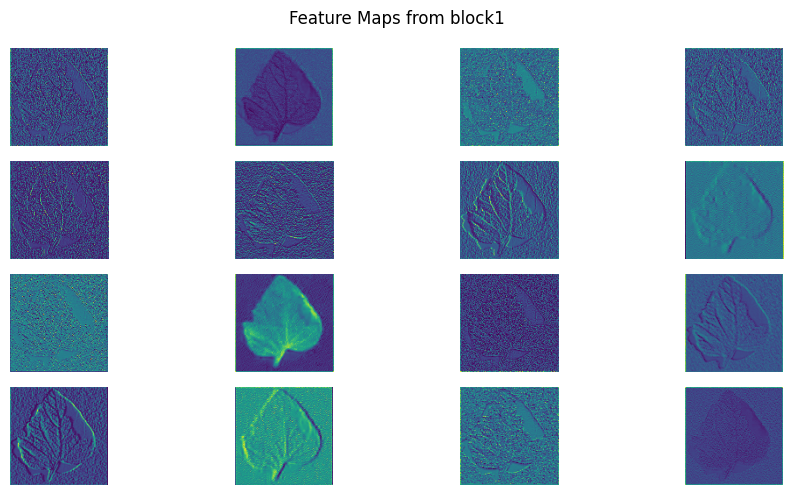

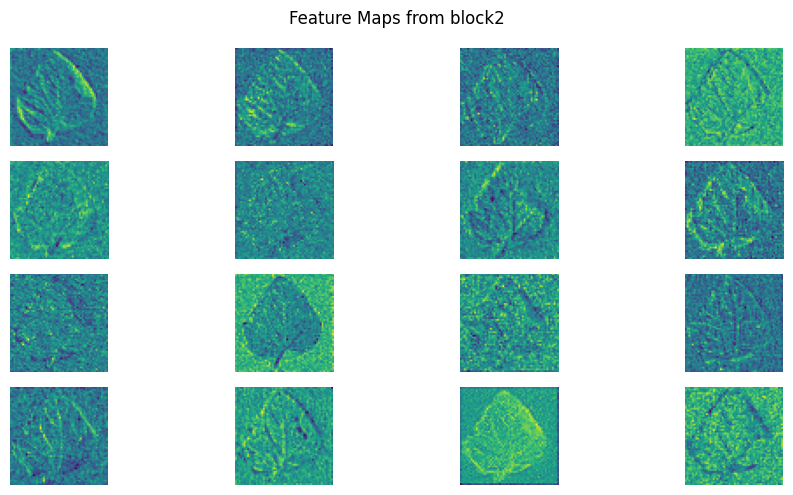

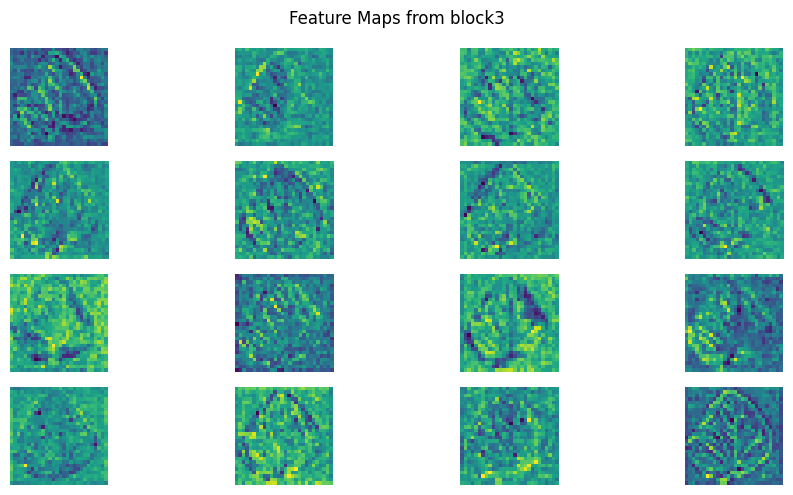

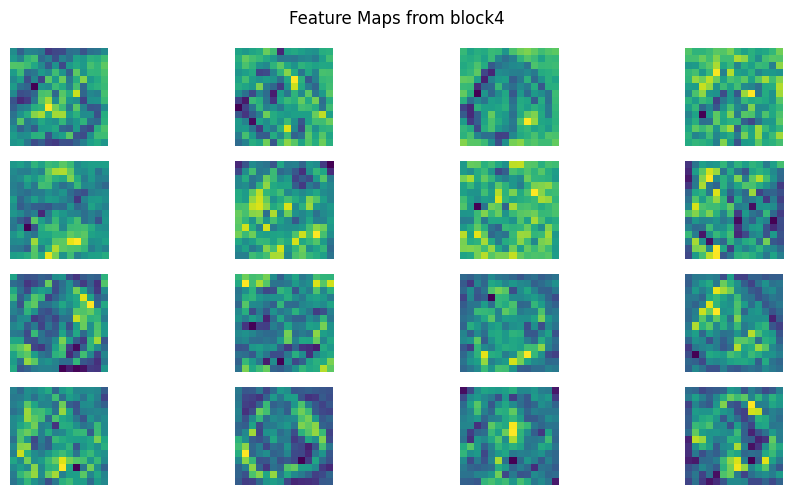

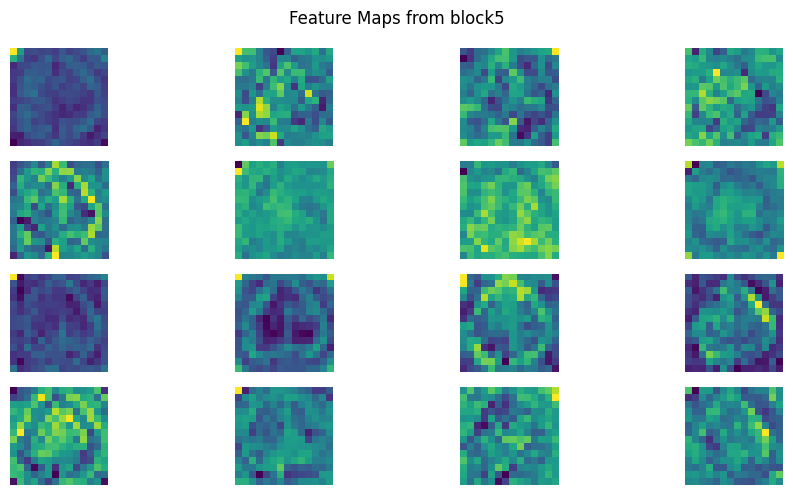

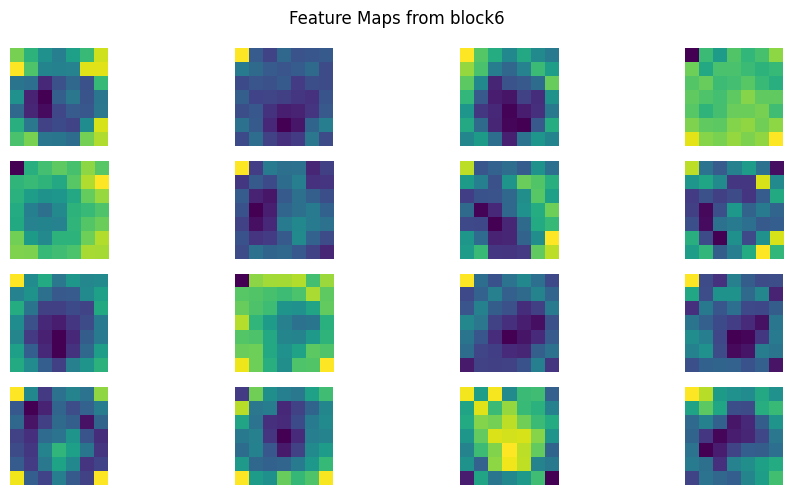

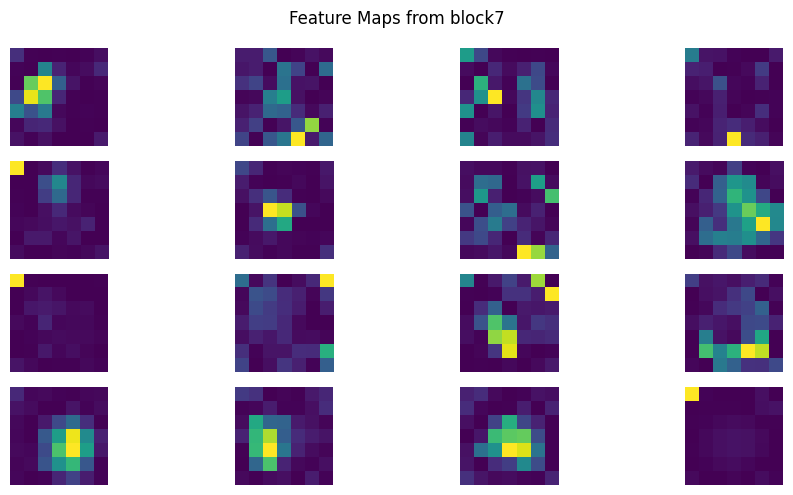

In [145]:
image_path = r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\Healthcheck\HEALTHY\0a0d6a11-ddd6-4dac-8469-d5f65af5afca___RS_HL 0555.JPG"
for i in range(1,8):
    visualize_feature_maps(model, image_path, device, block_idx=i, hook_name=f"block{i}")

In [21]:
loss=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [22]:
from tqdm.auto import tqdm

In [24]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter(log_dir='runs3/experiment1')

In [25]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

def train(model, dataloader, lossfn, optimizer, device):
    model.train()
    trainloss, trainacc = 0, 0

    for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Training', leave=False):
        x = x.to(device)
        y = y.float().unsqueeze(1).to(device)

        pred = model(x)
        loss = lossfn(pred, y)
        trainloss += loss.item()

        prob = torch.round(torch.sigmoid(pred))
        trainacc += accuracy_score(y.detach().view(-1).cpu().numpy(), prob.detach().view(-1).cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % max(1, len(dataloader) // 5) == 0:
            tqdm.write(f"🟩 Looked at {batch * len(x)}/{len(dataloader.dataset)} | Loss: {loss.item()}")

    trainloss /= len(dataloader)
    trainacc /= len(dataloader)
    print(f"\n✅ TRAINING COMPLETE — Loss: {trainloss:.4f} | Accuracy: {trainacc:.4f}")
    return trainloss, trainacc


def test(model, dataloader, lossfn, device):
    model.eval()
    testloss, testacc = 0, 0

    with torch.inference_mode():
        for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Testing', leave=False):
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)

            pred = model(x)
            loss = lossfn(pred, y)
            testloss += loss.item()

            prob = torch.round(torch.sigmoid(pred))
            testacc += accuracy_score(y.detach().view(-1).cpu().numpy(), prob.detach().view(-1).cpu().numpy())

            if batch % max(1, len(dataloader) // 5) == 0:
                tqdm.write(f"🟦 Looked at {batch * len(x)}/{len(dataloader.dataset)} | Loss: {loss.item()}")

    testloss /= len(dataloader)
    testacc /= len(dataloader)
    print(f"\n🔎 TESTING COMPLETE — Loss: {testloss:.4f} | Accuracy: {testacc:.4f}")
    return testloss, testacc


In [26]:

best_acc = 0.0             
best_model_state = None    
patience = 1
counter = 0
min_delta = 0.001         

train_loss, train_acc, test_loss, test_acc = [], [], [], []

epochs=15
for epoch in tqdm(range(epochs), desc='Training', ncols=150):
    print(f"\nEpoch --> [{epoch+1}]")
    
    trainloss, trainacc = train(model, trainloader, loss, optimizer, device)
    testloss, testacc = test(model, testloader, loss, device)
    writer.add_scalar("Loss/Train", trainloss, epoch)
    writer.add_scalar("Loss/Test", testloss, epoch)
    writer.add_scalar("Accuracy/Train", trainacc, epoch)
    writer.add_scalar("Accuracy/Test", testacc, epoch)

    train_loss.append(trainloss)
    train_acc.append(trainacc)
    test_loss.append(testloss)
    test_acc.append(testacc)

    # 🔍 Check for improvement in test accuracy
    if testacc > best_acc + min_delta:
        best_acc = testacc
        counter = 0
        best_model_state = model.state_dict()  # Save best model in memory
        print(f"✅ Best model updated at epoch {epoch+1} with test accuracy: {testacc:.4f}")
    else:
        counter += 1
        print(f"🛑 No improvement. Patience: {counter}/{patience}")

    if counter >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best accuracy: {best_acc:.4f}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n🎯 Best model loaded with test accuracy: {best_acc:.4f}")
writer.close()
torch.cuda.empty_cache()



Training:   0%|                                                                                               …


Epoch --> [1]


Training:   0%|          | 0/737 [00:00<?, ?it/s]

🟩 Looked at 0/23566 | Loss: 0.6991753578186035
🟩 Looked at 4704/23566 | Loss: 0.33673378825187683
🟩 Looked at 9408/23566 | Loss: 0.13835543394088745
🟩 Looked at 14112/23566 | Loss: 0.19428664445877075
🟩 Looked at 18816/23566 | Loss: 0.20173680782318115
🟩 Looked at 23520/23566 | Loss: 0.20705315470695496

✅ TRAINING COMPLETE — Loss: 0.2936 | Accuracy: 0.8947


Testing:   0%|          | 0/185 [00:00<?, ?it/s]

🟦 Looked at 0/5892 | Loss: 0.2105804681777954
🟦 Looked at 1184/5892 | Loss: 0.15002241730690002
🟦 Looked at 2368/5892 | Loss: 0.29665350914001465
🟦 Looked at 3552/5892 | Loss: 0.23950520157814026
🟦 Looked at 4736/5892 | Loss: 0.16243523359298706

🔎 TESTING COMPLETE — Loss: 0.1834 | Accuracy: 0.9426
✅ Best model updated at epoch 1 with test accuracy: 0.9426

Epoch --> [2]


Training:   0%|          | 0/737 [00:00<?, ?it/s]

🟩 Looked at 0/23566 | Loss: 0.21854199469089508
🟩 Looked at 4704/23566 | Loss: 0.33574792742729187
🟩 Looked at 9408/23566 | Loss: 0.5231397151947021
🟩 Looked at 14112/23566 | Loss: 0.17803671956062317
🟩 Looked at 18816/23566 | Loss: 0.16197404265403748
🟩 Looked at 23520/23566 | Loss: 0.1441776305437088

✅ TRAINING COMPLETE — Loss: 0.2042 | Accuracy: 0.9235


Testing:   0%|          | 0/185 [00:00<?, ?it/s]

🟦 Looked at 0/5892 | Loss: 0.1407053917646408
🟦 Looked at 1184/5892 | Loss: 0.11332434415817261
🟦 Looked at 2368/5892 | Loss: 0.21364960074424744
🟦 Looked at 3552/5892 | Loss: 0.20726649463176727
🟦 Looked at 4736/5892 | Loss: 0.2229098081588745

🔎 TESTING COMPLETE — Loss: 0.1580 | Accuracy: 0.9419
🛑 No improvement. Patience: 1/1

⛔ Early stopping triggered at epoch 2. Best accuracy: 0.9426

🎯 Best model loaded with test accuracy: 0.9426


In [116]:
dummy_input = torch.randn(1, 3, 227, 227).to(device)  
writer.add_graph(model, dummy_input)


In [ ]:
images, labels = next(iter(trainloader))
# Log input images
img_grid = torchvision.utils.make_grid(images[:16])  # First 16 images
writer.add_image('Sample Inputs', img_grid)


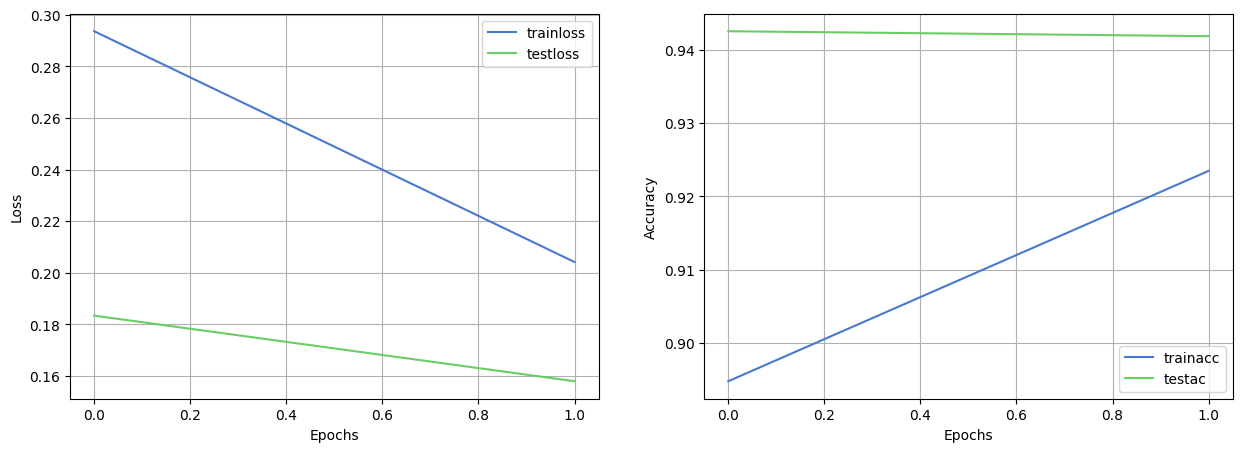

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss,)
plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['trainloss','testloss'])
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_acc,)
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['trainacc','testac'])
plt.grid(True)
plt.show()

In [28]:
y_pred,y_true=[],[]
model.eval()
with torch.inference_mode():
    for (xsam,ysam) in (testloader):
        xsam,ysam=xsam.to(device),ysam.to(device)
        testpred=model(xsam)
        testpred=torch.sigmoid(testpred)
        testprob=torch.round(testpred)
        y_pred.extend(testprob.detach().cpu().numpy())
        y_true.extend(ysam.detach().cpu().numpy())

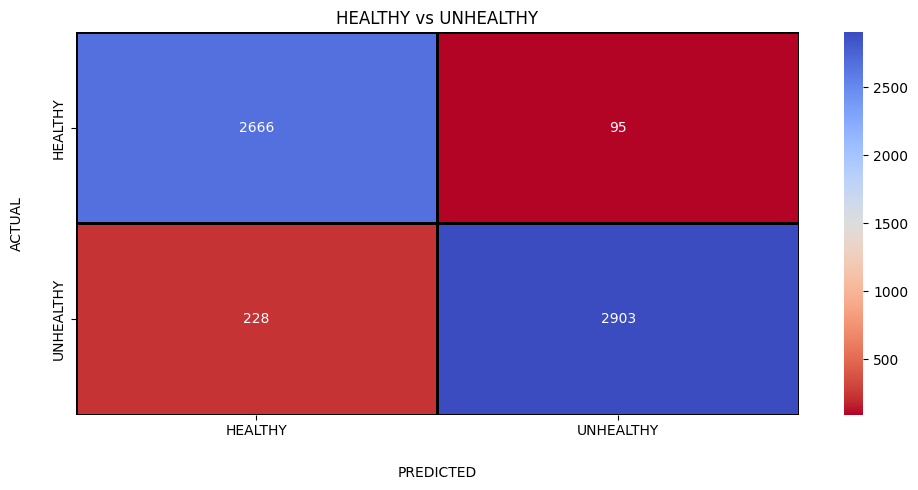

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(cm,fmt='d',annot=True,cmap=plt.cm.coolwarm_r,xticklabels=plotdata.classes,yticklabels=plotdata.classes,linecolor='black',linewidths=2)
plt.xticks()
plt.yticks()
plt.xlabel("PREDICTED",labelpad=20)
plt.ylabel("ACTUAL",labelpad=20)
plt.title("HEALTHY vs UNHEALTHY")
plt.tight_layout()
plt.show()

In [30]:
acc=accuracy_score(y_true,y_pred)*100
print(f"Mobilenet Accuracy on checking healthy or unhealthy plant : {acc:.2f} %")

Mobilenet Accuracy on checking healthy or unhealthy plant : 94.52 %


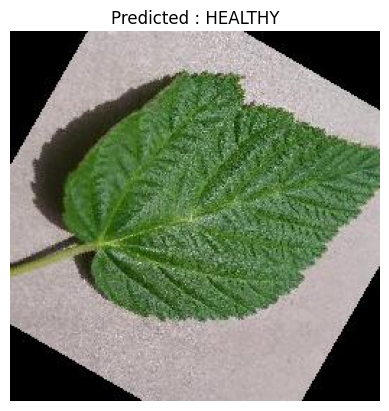

In [31]:
from PIL import Image
import torch
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt

# Load and transform image
img_path = r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PLANTorSOMETHING\PLANT\0a1b30a5-f81b-4fe8-9221-78ccba5e3a13___Mary_HL 6221_new30degFlipLR.JPG"
img = Image.open(img_path).convert("RGB")

image_size = 299
data_transform = v2.Compose([
    v2.Resize((image_size, image_size)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transform
transform_img = data_transform(img).unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.inference_mode():
    logit = model(transform_img)

    # Use sigmoid for binary classification
    prob = torch.sigmoid(logit)
    pred = torch.round(prob) # 0 or 1

# Class names
class_name = plotdata.classes  # Thi
pred_class = class_name[int(pred.item())]
# Show image and prediction
plt.imshow(img)
plt.title(f"Predicted : {pred_class}")
plt.axis("off")
plt.show()


In [32]:
torch.save(model, r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\MODELS-PLANTvsOTHERS\Efficientnet_full_model.pth")